# Expedia Hotel Recommendation

Data Description

Expedia has provided you logs of customer behavior. These include what customers searched for, how they interacted with search results (click/book), whether or not the search result was a travel package. The data in this competition is a random selection from Expedia and is not representative of the overall statistics.

Expedia is interested in predicting which hotel group a user is going to book. Expedia has in-house algorithms to form hotel clusters, where similar hotels for a search (based on historical price, customer star ratings, geographical locations relative to city center, etc) are grouped together. These hotel clusters serve as good identifiers to which types of hotels people are going to book, while avoiding outliers such as new hotels that don't have historical data.

Your goal of this competition is to predict the booking outcome (hotel cluster) for a user event, based on their search and other attributes associated with that user event.

The train and test datasets are split based on time: training data from 2013 and 2014, while test data are from 2015. The public/private leaderboard data are split base on time as well. Training data includes all the users in the logs, including both click events and booking events. Test data only includes booking events. 

destinations.csv data consists of features extracted from hotel reviews text. 

Note that some srch_destination_id's in the train/test files don't exist in the destinations.csv file. This is because some hotels are new and don't have enough features in the latent space. Your algorithm should be able to handle this missing information.

In [1]:
# train/test.csv

# date_time(string) : Timestamp 
# site_name(int) : ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, ...)
# posa_continent(int) : ID of continent associated with site_name
# user_location_country(int) : The ID of the country the customer is located
# user_location_region(int) : The ID of the region the customer is located
# user_location_city(int) : The ID of the city the customer is located
# orig_destination_distance(double) : Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated	double
# user_id(int) : ID of user
# is_mobile(tinyint) : 1 when a user connected from a mobile device, 0 otherwise
# is_package(int) : 1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise
# channel(int) : ID of a marketing channel
# srch_ci(string) : Checkin date
# srch_co(string) : Checkout date
# srch_adults_cnt(int) : The number of adults specified in the hotel room
# srch_children_cnt(int) : The number of (extra occupancy) children specified in the hotel room
# srch_rm_cnt(int) : The number of hotel rooms specified in the search
# srch_destination_id(int) : ID of the destination where the hotel search was performed
# srch_destination_type_id(int) : Type of destination
# hotel_continent(int) : Hotel continent
# hotel_country(int) : Hotel country
# hotel_market(int) : Hotel market
# is_booking(tinyint) : 1 if a booking, 0 if a click
# cnt(bigint) : Numer of similar events in the context of the same user session
# hotel_cluster(int) : ID of a hotel cluster

# 1. Data preprocessing & EDA

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import missingno as msno
import ml_metrics as metrics

In [3]:
destinations = pd.read_csv("destinations.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

### Check Dataset

In [4]:
print('train.shape :', train.shape)
print('test.shape :', test.shape)
print('destinations.shape', destinations.shape)

train.shape : (37670293, 24)
test.shape : (2528243, 22)
destinations.shape (62106, 150)


- train set 너무 많음(3700만 라인) --> 이대로 계속 분석 가능한지?(메모리 이슈) : sampling

In [5]:
# check destinationmissing values
destinations.tail() 

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
62101,64989,-2.145876,-2.158016,-2.216621,-2.158016,-2.006209,-2.102505,-2.216621,-2.157203,-2.216621,...,-2.216621,-2.158016,-2.158016,-2.216621,-2.216621,-2.216621,-2.216621,-2.216621,-2.216621,-2.152024
62102,64990,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.176802,-2.203479,-2.203479,-2.203479,...,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.008885
62103,64991,-2.190567,-2.208308,-2.208308,-2.208308,-2.208308,-2.135493,-2.208308,-2.208308,-1.909808,...,-2.188935,-2.208308,-2.175594,-2.208308,-2.208308,-2.199347,-2.208308,-2.208308,-2.208308,-2.208308
62104,64992,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,...,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686
62105,64993,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,...,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457


- row index와 srch_destination_id가 차이나는 것으로 보아, missing된 id가 존재하는 것으로 판단 (대략 5% 미만) -> 어떻게 처리할지? : 비율이 적어 삭제해도 무방할 듯

In [6]:
train.tail()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
37670288,2014-09-02 08:08:28,2,3,66,174,26232,2348.4075,1198182,0,1,...,0,1,8855,1,0,1,2,50,213,26
37670289,2014-09-08 14:52:52,2,3,66,174,26232,679.6104,1198182,0,0,...,0,1,8281,1,0,1,2,50,663,9
37670290,2014-09-15 06:56:51,2,3,66,174,26232,668.1768,1198182,0,0,...,0,1,5620,3,0,1,2,50,663,94
37670291,2014-09-18 08:49:33,2,3,66,462,12565,106.4274,1198182,0,0,...,0,1,18811,1,0,1,2,50,592,42
37670292,2014-09-18 08:52:42,2,3,66,462,12565,106.4274,1198182,0,0,...,0,1,18811,1,1,1,2,50,592,42


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37670293 entries, 0 to 37670292
Data columns (total 24 columns):
date_time                    object
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
orig_destination_distance    float64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_ci                      object
srch_co                      object
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
is_booking                   int64
cnt                          int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
hotel_cluster                int64
dtypes: float64(1), int64(20), object(3)

- 대부분 integer, float variable
- date time는 년,월,일,시 등으로 format 변경 필요
- user_loaction_country, user_location_city value의 정확한 의미 알 수 없어 사용이 어려워 보임 (keep)
- orig_destination_distance Nan 어떻게 처리할지? --> data description에 의하면 Nan value는 계산이 불가능한 경우 :
    - A null means the distance could not be calculated

In [8]:
test.tail()

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
2528238,2528238,2015-06-16 21:03:12,2,3,66,174,18037,2466.1247,1198754,1,...,2015-07-27,2015-07-30,2,1,1,8857,1,2,50,214
2528239,2528239,2015-07-25 10:12:14,11,3,205,354,48951,4701.6346,1198758,0,...,2015-07-29,2015-08-05,2,0,1,19308,3,6,206,1749
2528240,2528240,2015-03-14 01:31:37,2,3,66,442,17078,1077.2278,1198771,0,...,2015-05-18,2015-05-19,1,0,1,8250,1,2,50,628
2528241,2528241,2015-07-21 11:23:35,2,3,66,184,28561,266.7678,1198775,0,...,2015-07-24,2015-07-25,2,0,1,4627,3,2,50,905
2528242,2528242,2015-02-25 16:00:29,2,3,229,249,56090,NaN,1198782,1,...,2015-02-26,2015-02-27,2,0,1,38774,6,3,162,1490


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2528243 entries, 0 to 2528242
Data columns (total 22 columns):
id                           int64
date_time                    object
site_name                    int64
posa_continent               int64
user_location_country        int64
user_location_region         int64
user_location_city           int64
orig_destination_distance    float64
user_id                      int64
is_mobile                    int64
is_package                   int64
channel                      int64
srch_ci                      object
srch_co                      object
srch_adults_cnt              int64
srch_children_cnt            int64
srch_rm_cnt                  int64
srch_destination_id          int64
srch_destination_type_id     int64
hotel_continent              int64
hotel_country                int64
hotel_market                 int64
dtypes: float64(1), int64(18), object(3)
memory usage: 424.4+ MB


In [10]:
train.describe()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
count,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,2.414529e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,...,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07,3.767029e+07
mean,9.795271e+00,2.680473e+00,8.610880e+01,3.084060e+02,2.775304e+04,1.970090e+03,6.044518e+05,1.349265e-01,2.489042e-01,5.870761e+00,...,3.321222e-01,1.112663e+00,1.444109e+04,2.582280e+00,7.965675e-02,1.483384e+00,3.156305e+00,8.129685e+01,6.004619e+02,4.980861e+01
std,1.196754e+01,7.480393e-01,5.924310e+01,2.084437e+02,1.678255e+04,2.232442e+03,3.506175e+05,3.416451e-01,4.323782e-01,3.717095e+00,...,7.314981e-01,4.591155e-01,1.106630e+04,2.153019e+00,2.707611e-01,1.219776e+00,1.623189e+00,5.617119e+01,5.117391e+02,2.891595e+01
min,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.600000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.000000e+00,6.600000e+01,1.740000e+02,1.300900e+04,3.131670e+02,2.989100e+05,0.000000e+00,0.000000e+00,2.000000e+00,...,0.000000e+00,1.000000e+00,8.267000e+03,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+01,1.600000e+02,2.500000e+01
50%,2.000000e+00,3.000000e+00,6.600000e+01,3.140000e+02,2.765500e+04,1.140491e+03,6.039140e+05,0.000000e+00,0.000000e+00,9.000000e+00,...,0.000000e+00,1.000000e+00,9.147000e+03,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,5.000000e+01,5.930000e+02,4.900000e+01
75%,1.400000e+01,3.000000e+00,7.000000e+01,3.850000e+02,4.241300e+04,2.552599e+03,9.101680e+05,0.000000e+00,0.000000e+00,9.000000e+00,...,0.000000e+00,1.000000e+00,1.879000e+04,5.000000e+00,0.000000e+00,2.000000e+00,4.000000e+00,1.060000e+02,7.010000e+02,7.300000e+01
max,5.300000e+01,4.000000e+00,2.390000e+02,1.027000e+03,5.650800e+04,1.240790e+04,1.198785e+06,1.000000e+00,1.000000e+00,1.000000e+01,...,9.000000e+00,8.000000e+00,6.510700e+04,9.000000e+00,1.000000e+00,2.690000e+02,6.000000e+00,2.120000e+02,2.117000e+03,9.900000e+01


In [11]:
test.describe()

,id,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
count,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,1.680782e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06,2.528243e+06
mean,1.264121e+06,9.709666e+00,2.697413e+00,8.551612e+01,3.170341e+02,2.786218e+04,1.686398e+03,6.026459e+05,1.425978e-01,1.093253e-01,6.493726e+00,1.958127e+00,2.507413e-01,1.117410e+00,1.656862e+04,2.941702e+00,3.022615e+00,8.125454e+01,6.464926e+02
std,7.298410e+05,1.227183e+01,7.651288e-01,5.673880e+01,2.082834e+02,1.668788e+04,2.197361e+03,3.469651e+05,3.496623e-01,3.120470e-01,3.931422e+00,8.980415e-01,6.754566e-01,4.615010e-01,1.280502e+04,2.282006e+00,1.674879e+00,5.507528e+01,5.046530e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.600000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.320605e+05,2.000000e+00,3.000000e+00,6.600000e+01,1.740000e+02,1.354200e+04,2.080691e+02,3.020785e+05,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,8.267000e+03,1.000000e+00,2.000000e+00,5.000000e+01,2.750000e+02
50%,1.264121e+06,2.000000e+00,3.000000e+00,6.600000e+01,3.180000e+02,2.765500e+04,7.278764e+02,6.041940e+05,0.000000e+00,0.000000e+00,9.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,1.201200e+04,1.000000e+00,2.000000e+00,5.000000e+01,6.280000e+02
75%,1.896182e+06,1.300000e+01,3.000000e+00,6.900000e+01,3.980000e+02,4.232800e+04,2.222729e+03,9.038295e+05,0.000000e+00,0.000000e+00,1.000000e+01,2.000000e+00,0.000000e+00,1.000000e+00,2.354100e+04,6.000000e+00,4.000000e+00,1.050000e+02,7.830000e+02
max,2.528242e+06,5.300000e+01,4.000000e+00,2.390000e+02,1.027000e+03,5.650900e+04,1.220623e+04,1.198785e+06,1.000000e+00,1.000000e+00,1.000000e+01,9.000000e+00,9.000000e+00,8.000000e+00,6.578000e+04,9.000000e+00,6.000000e+00,2.120000e+02,2.117000e+03


In [12]:
# print(len(train.columns), train.columns)
# print(len(test.columns), test.columns)

### Check missing values in data 

In [13]:
for col in train.columns:
    msg = '{:>10}\t\t\t Percent of NaN value: {:.2f}%'.format(col, 100 * (train[col].isnull().sum() / train[col].shape[0]))
    print(msg)

 date_time			 Percent of NaN value: 0.00%
 site_name			 Percent of NaN value: 0.00%
posa_continent			 Percent of NaN value: 0.00%
user_location_country			 Percent of NaN value: 0.00%
user_location_region			 Percent of NaN value: 0.00%
user_location_city			 Percent of NaN value: 0.00%
orig_destination_distance			 Percent of NaN value: 35.90%
   user_id			 Percent of NaN value: 0.00%
 is_mobile			 Percent of NaN value: 0.00%
is_package			 Percent of NaN value: 0.00%
   channel			 Percent of NaN value: 0.00%
   srch_ci			 Percent of NaN value: 0.12%
   srch_co			 Percent of NaN value: 0.12%
srch_adults_cnt			 Percent of NaN value: 0.00%
srch_children_cnt			 Percent of NaN value: 0.00%
srch_rm_cnt			 Percent of NaN value: 0.00%
srch_destination_id			 Percent of NaN value: 0.00%
srch_destination_type_id			 Percent of NaN value: 0.00%
is_booking			 Percent of NaN value: 0.00%
       cnt			 Percent of NaN value: 0.00%
hotel_continent			 Percent of NaN value: 0.00%
hotel_country			 Percent of 

- Train.csv column
    - ID 없음

In [14]:
Nan_ci_idx = list(train.loc[train['srch_ci'].isnull()]['srch_ci'].index)
Nan_co_idx = list(train.loc[train['srch_co'].isnull()]['srch_co'].index)
print(len(Nan_ci_idx))
print(len(Nan_co_idx))

equal_idx = 0
for i in range(len(Nan_ci_idx)):
    if Nan_ci_idx[i] in Nan_co_idx:
        equal_idx += 1

print(equal_idx)

47083
47084
47079


- Checkin data와 Checkout data의 누락이 대부분 겹치치만, 각각 누락된 것도 있음

In [15]:
# delete srch_ci, srch_co nan row 
train.dropna(subset=['srch_ci', 'srch_co'], axis=0, inplace=True)

# check result
after_Nan_ci_idx = list(train.loc[train['srch_ci'].isnull()]['srch_ci'].index)
after_Nan_co_idx = list(train.loc[train['srch_co'].isnull()]['srch_co'].index)
print(len(after_Nan_ci_idx))
print(len(after_Nan_co_idx))

equal_idx = 0
for i in range(len(after_Nan_ci_idx)):
    if after_Nan_ci_idx[i] in after_Nan_co_idx:
        equal_idx += 1

print(equal_idx)

0
0
0


- srch_ci, srch_co 결측치 삭제 완료

In [16]:
for col in test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (test[col].isnull().sum() / test[col].shape[0]))
    print(msg)

column:         id	 Percent of NaN value: 0.00%
column:  date_time	 Percent of NaN value: 0.00%
column:  site_name	 Percent of NaN value: 0.00%
column: posa_continent	 Percent of NaN value: 0.00%
column: user_location_country	 Percent of NaN value: 0.00%
column: user_location_region	 Percent of NaN value: 0.00%
column: user_location_city	 Percent of NaN value: 0.00%
column: orig_destination_distance	 Percent of NaN value: 33.52%
column:    user_id	 Percent of NaN value: 0.00%
column:  is_mobile	 Percent of NaN value: 0.00%
column: is_package	 Percent of NaN value: 0.00%
column:    channel	 Percent of NaN value: 0.00%
column:    srch_ci	 Percent of NaN value: 0.00%
column:    srch_co	 Percent of NaN value: 0.00%
column: srch_adults_cnt	 Percent of NaN value: 0.00%
column: srch_children_cnt	 Percent of NaN value: 0.00%
column: srch_rm_cnt	 Percent of NaN value: 0.00%
column: srch_destination_id	 Percent of NaN value: 0.00%
column: srch_destination_type_id	 Percent of NaN value: 0.00%
col

- test set은 missing value 없음
- is_booking, cnt, hotel_cluster(label) column 없음

In [17]:
# msno.bar(df=train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))
# msno.matrix(df=train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

In [18]:
# msno.bar(df=test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))
# msno.matrix(df=test.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

### Check target label

In [19]:
train['hotel_cluster'].value_counts()

91    1042562
41     771819
48     753308
64     703398
65     670320
       ...   
35     138967
53     134517
88     107729
27     104795
74      48276
Name: hotel_cluster, Length: 100, dtype: int64

48276 1042562


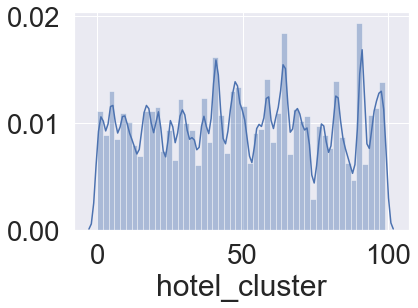

In [20]:
sns.distplot(train['hotel_cluster'])
print(min(train['hotel_cluster'].value_counts()), max(train['hotel_cluster'].value_counts()))

### Convert Dates to Year & Month for original Train set

In [21]:
# train['date_time'] = pd.to_datetime(train['date_time'])
# train['year'] = train['date_time'].dt.year
# train['month'] = train['date_time'].dt.month
# train['day'] = train['date_time'].dt.day
# train.head()

### Downsizing dataset (by User random sampling)

In [22]:
userid_group = train.groupby(['user_id'])['hotel_cluster'].value_counts()
print(userid_group)
print('unique user count :',train['user_id'].nunique())

user_id  hotel_cluster
0        19               1
         28               1
         40               1
         56               1
         72               1
                         ..
1198784  79               2
         26               1
         68               1
         95               1
1198785  76               2
Name: hotel_cluster, Length: 14851034, dtype: int64
unique user count : 1198671


- 1,198,786 user -> 40,000 user random sampling (Considering computation resource)

In [23]:
unique_user_set = set(train['user_id'].unique())
sampling_user_set = random.sample(unique_user_set, 40000)

train_sampling = pd.DataFrame()
train_chunking = pd.read_csv('train.csv', chunksize = 100000)

for c in train_chunking:
    train_sampling = train_sampling.append(c.loc[c['user_id'].isin(sampling_user_set)])

print('sampling unique user count :',train_sampling['user_id'].nunique())    

sampling unique user count : 40000


In [24]:
train_sampling['date_time'] = pd.to_datetime(train_sampling['date_time'])
train_sampling['year'] = train_sampling['date_time'].dt.year
train_sampling['month'] = train_sampling['date_time'].dt.month
train_sampling['day'] = train_sampling['date_time'].dt.day
train_sampling.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,day
6,2014-07-16 09:42:23,2,3,66,189,10067,NaN,501,0,0,...,1,0,2,2,50,675,41,2014,7,16
7,2014-07-16 09:45:48,2,3,66,189,10067,NaN,501,0,1,...,1,0,1,2,50,675,41,2014,7,16
8,2014-07-16 09:52:11,2,3,66,189,10067,NaN,501,0,0,...,1,0,1,2,50,675,69,2014,7,16
9,2014-07-16 09:55:24,2,3,66,189,10067,NaN,501,0,0,...,1,0,1,2,50,675,70,2014,7,16
10,2014-07-16 10:00:06,2,3,66,189,10067,NaN,501,0,0,...,1,0,1,2,50,675,98,2014,7,16


In [25]:
# delete srch_ci, srch_co nan row in train_sampling
train_sampling.dropna(subset=['srch_ci', 'srch_co'], axis=0, inplace=True)

In [26]:
# orig_destination_distance 
print(train_sampling['orig_destination_distance'].median(skipna=True))
print(train_sampling['orig_destination_distance'].mean(skipna=True))
train_sampling['orig_destination_distance'].describe()

1120.5654
1932.4106221667603


count    803512.000000
mean       1932.410622
std        2188.179735
min           0.005600
25%         312.925975
50%        1120.565400
75%        2509.753700
max       12281.641300
Name: orig_destination_distance, dtype: float64

In [28]:
train_sampling.groupby(['user_id'])['orig_destination_distance'].describe()

,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
30,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,2.0,1220.642750,348.772005,974.0237,1097.333225,1220.64275,1343.952275,1467.2618
133,44.0,316.330664,95.450133,25.6352,331.294825,331.78590,344.211650,383.1496
139,47.0,383.125798,615.281660,1.6050,76.936050,90.47140,290.045350,2273.3549
142,8.0,350.169800,141.398684,125.5338,300.194250,436.01965,437.312500,445.2121
...,...,...,...,...,...,...,...,...
1198529,49.0,859.537192,69.385169,762.9907,777.151100,913.27170,913.930500,916.3188
1198564,21.0,1142.348700,1217.614233,82.8894,125.307300,880.32410,1723.276200,3603.0790
1198593,8.0,1037.310025,1.617216,1036.3179,1036.419225,1036.86630,1037.230600,1041.1976


In [29]:
hotel_distance = train_sampling.groupby(['hotel_cluster'])['orig_destination_distance'].describe()
# print(hotel_distance)

- orig_destination_distance
    - 거리개념이라 음수또는 0으로 처리하기엔 좋지 않음
    - 전체 mean, median을 일괄적용하기에는 Nan 비율이 너무 높음
    - 각 유저별 mean 또는 median을 고려하기엔 user_id별 로그가 전혀없는 것들이 있음
    - Hotel_cluster별 mean을 적용해보자

In [30]:
cluster_avg_distance = pd.DataFrame(hotel_distance['mean'].tolist(), columns=['avg_distance'])
cluster_avg_distance['hotel_cluster'] = pd.DataFrame(cluster_avg_distance.index.tolist())
print(cluster_avg_distance)

    avg_distance  hotel_cluster
0    1923.863493              0
1    1329.977578              1
2    2781.972748              2
3    2670.287158              3
4    1168.517484              4
..           ...            ...
95   1242.021651             95
96   1509.448522             96
97   2948.372650             97
98   1843.371440             98
99   2793.236980             99

[100 rows x 2 columns]


In [44]:
train_sampling = pd.merge(train_sampling, cluster_avg_distance, how='inner', on='hotel_cluster', left_index=True)
train_sampling.orig_destination_distance.fillna(train_sampling.avg_distance, inplace=True)

In [45]:
train_sampling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1246962 entries, 41 to 27
Data columns (total 28 columns):
date_time                    1246962 non-null datetime64[ns]
site_name                    1246962 non-null int64
posa_continent               1246962 non-null int64
user_location_country        1246962 non-null int64
user_location_region         1246962 non-null int64
user_location_city           1246962 non-null int64
orig_destination_distance    1246962 non-null float64
user_id                      1246962 non-null int64
is_mobile                    1246962 non-null int64
is_package                   1246962 non-null int64
channel                      1246962 non-null int64
srch_ci                      1246962 non-null object
srch_co                      1246962 non-null object
srch_adults_cnt              1246962 non-null int64
srch_children_cnt            1246962 non-null int64
srch_rm_cnt                  1246962 non-null int64
srch_destination_id          1246962 non-null 

In [46]:
train_sampling = train_sampling.drop("avg_distance", axis=1)
train_sampling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1246962 entries, 41 to 27
Data columns (total 27 columns):
date_time                    1246962 non-null datetime64[ns]
site_name                    1246962 non-null int64
posa_continent               1246962 non-null int64
user_location_country        1246962 non-null int64
user_location_region         1246962 non-null int64
user_location_city           1246962 non-null int64
orig_destination_distance    1246962 non-null float64
user_id                      1246962 non-null int64
is_mobile                    1246962 non-null int64
is_package                   1246962 non-null int64
channel                      1246962 non-null int64
srch_ci                      1246962 non-null object
srch_co                      1246962 non-null object
srch_adults_cnt              1246962 non-null int64
srch_children_cnt            1246962 non-null int64
srch_rm_cnt                  1246962 non-null int64
srch_destination_id          1246962 non-null 

In [47]:
train_sampling.groupby(['year'])['month'].value_counts()

year  month
2013  7        35730
      3        33502
      6        33406
      10       32609
      8        32567
      9        31312
      5        31236
      4        30086
      12       27364
      11       26544
      2        26144
      1        24078
2014  12       96582
      10       94465
      7        92472
      8        90617
      9        90328
      11       87238
      6        71912
      5        63165
      4        60076
      3        57356
      1        40729
      2        37444
Name: month, dtype: int64

In [48]:
train_sampling.groupby(['user_id'])['hotel_cluster'].value_counts()
train_sampling.groupby(['hotel_cluster'])['user_id'].value_counts()

hotel_cluster  user_id
0              984671     65
               22248      34
               601794     29
               422242     27
               537296     27
                          ..
99             1197483     1
               1197509     1
               1197871     1
               1197985     1
               1198449     1
Name: user_id, Length: 495466, dtype: int64

In [49]:
print(min(train_sampling.groupby(['user_id'])['hotel_cluster'].value_counts()))
print(max(train_sampling.groupby(['user_id'])['hotel_cluster'].value_counts()))

1
223


### Train / Test split by train_sampling (ratio 80:20)

- month 기준으로 분할 (일 기준으로 나눌 수 있지만, 분석의 용이성을 높이고자)
- 24 month data를 8:2로 나누면, 대략 19 : 5 

In [50]:
train_new = train_sampling[((train_sampling.year == 2013) | ((train_sampling.year == 2014) & (train_sampling.month <= 7)))]
test_new = train_sampling[((train_sampling.year == 2014) & (train_sampling.month >= 8))]

In [51]:
test_new = test_new[test_new.is_booking == 1]
test_new

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,year,month,day
41,2014-10-21 14:10:18,2,3,215,869,34618,2074.668100,825539,0,0,...,1,1,1,2,50,675,41,2014,10,21
41,2014-10-10 17:40:31,33,2,194,38,42328,1513.632771,1016093,0,0,...,1,1,1,6,70,19,41,2014,10,10
41,2014-08-27 07:47:01,2,3,66,293,17552,71.233400,216424,0,0,...,6,1,1,2,50,644,41,2014,8,27
41,2014-08-17 08:05:25,2,3,66,337,22293,307.796800,385535,0,0,...,1,1,1,2,50,697,41,2014,8,17
41,2014-09-17 09:54:54,11,3,205,354,25315,342.371500,901327,0,0,...,1,1,1,2,50,675,41,2014,9,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,2014-11-07 16:29:58,2,3,66,184,2037,1046.498700,1072140,1,0,...,1,1,1,2,50,1179,27,2014,11,7
27,2014-09-07 21:06:32,24,2,3,50,5703,6217.016099,599755,0,0,...,1,1,1,3,36,1617,27,2014,9,7
27,2014-09-07 21:13:27,24,2,3,50,5703,6217.016099,599755,0,0,...,1,1,1,3,36,1615,27,2014,9,7
27,2014-09-01 13:40:55,37,1,69,918,15644,6217.016099,355678,0,0,...,1,1,1,0,34,1705,27,2014,9,1


In [52]:
for col in train_new.columns:
    print(col, train_new[col].isnull().sum())

date_time 0
site_name 0
posa_continent 0
user_location_country 0
user_location_region 0
user_location_city 0
orig_destination_distance 0
user_id 0
is_mobile 0
is_package 0
channel 0
srch_ci 0
srch_co 0
srch_adults_cnt 0
srch_children_cnt 0
srch_rm_cnt 0
srch_destination_id 0
srch_destination_type_id 0
is_booking 0
cnt 0
hotel_continent 0
hotel_country 0
hotel_market 0
hotel_cluster 0
year 0
month 0
day 0


### Feature correlation analysis

In [53]:
train.corr()[train.corr()>0.5]

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
site_name,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
posa_continent,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_location_country,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_location_region,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_location_city,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
orig_destination_distance,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_mobile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_package,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
channel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
# most missing feature : orig_destination_distance 
# Physical distance between a hotel and a customer at the time of search. 
# A null means the distance could not be calculated
train.corr()['orig_destination_distance']

site_name                    0.030385
posa_continent               0.048022
user_location_country        0.047780
user_location_region         0.139154
user_location_city           0.012771
orig_destination_distance    1.000000
user_id                      0.015486
is_mobile                   -0.054984
is_package                   0.038853
channel                      0.003013
srch_adults_cnt             -0.024019
srch_children_cnt           -0.061436
srch_rm_cnt                 -0.007588
srch_destination_id         -0.027335
srch_destination_type_id    -0.039240
is_booking                  -0.037753
cnt                          0.009995
hotel_continent              0.414819
hotel_country                0.255033
hotel_market                -0.087780
hotel_cluster                0.007250
Name: orig_destination_distance, dtype: float64

In [55]:
train.corr()['hotel_cluster']

site_name                   -0.022455
posa_continent               0.014972
user_location_country       -0.010467
user_location_region         0.007445
user_location_city           0.000830
orig_destination_distance    0.007250
user_id                      0.001046
is_mobile                    0.008403
is_package                   0.038770
channel                      0.000772
srch_adults_cnt              0.012318
srch_children_cnt            0.016303
srch_rm_cnt                 -0.005937
srch_destination_id         -0.011702
srch_destination_type_id    -0.032850
is_booking                  -0.021540
cnt                          0.002958
hotel_continent             -0.013972
hotel_country               -0.024297
hotel_market                 0.034229
hotel_cluster                1.000000
Name: hotel_cluster, dtype: float64

- hotel_cluster와 선형 상관관계가 있는 feature는 없으므로, linear regression은 적합하지 않음
- ML model을 돌리기 위한 추가 피처 고려 필요 (destination.csv)

### Additional feature generation with PCA

In [56]:
destinations.isnull().sum()

srch_destination_id    0
d1                     0
d2                     0
d3                     0
d4                     0
                      ..
d145                   0
d146                   0
d147                   0
d148                   0
d149                   0
Length: 150, dtype: int64

In [58]:
destinations.tail()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
62101,64989,-2.145876,-2.158016,-2.216621,-2.158016,-2.006209,-2.102505,-2.216621,-2.157203,-2.216621,...,-2.216621,-2.158016,-2.158016,-2.216621,-2.216621,-2.216621,-2.216621,-2.216621,-2.216621,-2.152024
62102,64990,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.176802,-2.203479,-2.203479,-2.203479,...,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.203479,-2.008885
62103,64991,-2.190567,-2.208308,-2.208308,-2.208308,-2.208308,-2.135493,-2.208308,-2.208308,-1.909808,...,-2.188935,-2.208308,-2.175594,-2.208308,-2.208308,-2.199347,-2.208308,-2.208308,-2.208308,-2.208308
62104,64992,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,...,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686,-2.173686
62105,64993,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,...,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457,-2.179457


In [57]:
from sklearn.decomposition import PCA

pca_full = PCA(n_components=149)
destination_full_components = pca_full.fit_transform(destinations[["d{0}".format(i + 1) for i in range(149)]])
# print('eigen_value :', pca_full.explained_variance_)
# print('explained variance ratio :', pca_full.explained_variance_ratio_)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
# print(cumsum)
dim = np.argmax(cumsum >= 0.95) + 1

print('dim over 95% :', dim)

pca = PCA(n_components=dim)

destination_compression = pca.fit_transform(destinations[["d{0}".format(i + 1) for i in range(dim)]])
destination_compression = pd.DataFrame(destination_compression)
destination_compression["srch_destination_id"] = destinations["srch_destination_id"]
print('eigen_value :', pca.explained_variance_)
print('explained variance ratio :', pca.explained_variance_ratio_)

dim over 95% : 59
eigen_value : [1.33796148e-01 4.37839689e-02 1.64992509e-02 1.05243006e-02
 8.51697829e-03 7.43482719e-03 5.41283488e-03 5.00334788e-03
 4.62699828e-03 4.21918110e-03 4.02831730e-03 3.41985519e-03
 3.30528498e-03 2.74492441e-03 2.39678967e-03 2.18418613e-03
 2.08894600e-03 1.79458021e-03 1.58528393e-03 1.46633654e-03
 1.38214814e-03 1.34457526e-03 1.22998071e-03 1.14075096e-03
 9.85827897e-04 9.45535061e-04 9.04673255e-04 8.95176773e-04
 8.55647559e-04 8.42680753e-04 8.03237676e-04 7.58006761e-04
 7.29294842e-04 7.09553681e-04 6.81639308e-04 6.51588247e-04
 6.12041941e-04 5.77676406e-04 5.77381646e-04 5.19508649e-04
 4.53438583e-04 4.20811169e-04 4.18506564e-04 3.87035240e-04
 3.60449382e-04 3.52005231e-04 3.23297672e-04 2.84389756e-04
 2.58614676e-04 2.08958314e-04 2.03424998e-04 1.64575581e-04
 1.32036399e-04 1.00296024e-04 7.93844919e-05 7.18735341e-05
 6.64323696e-05 4.00736625e-05 2.64411876e-05]
explained variance ratio : [4.67277392e-01 1.52913661e-01 5.7622936

- 누적된 분산의 비율이 95%가 되도록 차원 결정

In [59]:
destination_compression.tail()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,srch_destination_id
62101,0.029696,-0.127091,-0.070902,-0.104755,0.051737,-0.164199,-0.109526,0.140397,-0.024035,-0.057789,...,0.003810,0.007386,-0.004411,-0.000290,0.000731,0.000850,-0.000514,0.001309,-0.000202,64989
62102,0.067459,-0.122185,0.131153,-0.126104,-0.020420,-0.050930,0.008845,-0.172922,0.060353,0.005388,...,0.001173,-0.001378,0.003728,0.003155,0.005229,-0.000396,0.005985,0.003530,0.000121,64990
62103,0.211431,0.213006,0.191408,-0.071127,-0.011591,-0.198628,-0.071205,-0.060756,-0.018403,0.061277,...,0.004020,-0.001225,0.002305,-0.003918,0.005585,0.000603,0.004048,0.004707,-0.000278,64991
62104,-0.434738,0.000715,0.014079,-0.001147,0.012949,0.031356,-0.029767,0.011838,0.041566,0.017022,...,-0.000269,-0.000827,0.001256,-0.001244,0.000396,-0.000500,-0.000384,-0.000264,-0.000081,64992
62105,-0.235575,-0.006823,0.090490,0.040452,0.011175,-0.081208,-0.060109,0.011503,0.010313,-0.016446,...,0.000103,-0.000098,0.000879,-0.001875,0.000249,-0.000558,-0.000034,0.000426,-0.000029,64993


In [60]:
destination_compression.isnull().sum()

0                      0
1                      0
2                      0
3                      0
4                      0
5                      0
6                      0
7                      0
8                      0
9                      0
10                     0
11                     0
12                     0
13                     0
14                     0
15                     0
16                     0
17                     0
18                     0
19                     0
20                     0
21                     0
22                     0
23                     0
24                     0
25                     0
26                     0
27                     0
28                     0
29                     0
30                     0
31                     0
32                     0
33                     0
34                     0
35                     0
36                     0
37                     0
38                     0
39                     0


### Generate new feature

- date_time 관련 time property에 대한 피처 추가
- srch_in, srch_out 관련 date property에 대한 피처 추가
- train_sampling feature와 destinations pca 결과 feature를 concat
- train_sampling data set으로 학습

In [71]:
def gen_new_features(train_df): 
    train_sampling["date_time"] = pd.to_datetime(train_sampling["date_time"])
    train_sampling["srch_ci"] = pd.to_datetime(train_sampling["srch_ci"], format='%Y-%m-%d', errors="coerce")
    train_sampling["srch_co"] = pd.to_datetime(train_sampling["srch_co"], format='%Y-%m-%d', errors="coerce")
    
    new_features = {}
    
    # Add time feature of date_time
    kind_of_time = ["quarter", "month", "dayofweek", "day", "hour", "minute"]
    for t in kind_of_time:
        new_features[t] = getattr(train_df["date_time"].dt, t)
    
    # Add date feature of srch_ci, srch_co & 
    kind_of_date = ["month", "day", "dayofweek", "quarter"]
    for d in kind_of_date:
        new_features["ci_{0}".format(d)] = getattr(train_df["srch_ci"].dt, d)
        new_features["co_{0}".format(d)] = getattr(train_df["srch_co"].dt, d)
    new_features["duration_of_stay"] = (train_df["srch_co"] - train_df["srch_ci"]).astype('timedelta64[h]')
    
    # Add others feature
    column_others = [p for p in train_df.columns if p not in ["date_time", "srch_ci", "srch_co"]]
    for c in column_others:
        new_features[c] = train_df[c]
    
    new_features_df = pd.DataFrame(new_features)
    
    # Concat destinations features
    new_features_df = new_features_df.join(destination_compression, 
                                           on="srch_destination_id", 
                                           how='left', 
                                           rsuffix="destination_compression")
#     new_features_df = new_features_df.drop("srch_destination_iddestination_compression", axis=1)

    return new_features_df

train_new_feature = gen_new_features(train_sampling)
train_new_feature

,quarter,month,dayofweek,day,hour,minute,ci_month,co_month,ci_day,co_day,...,50,51,52,53,54,55,56,57,58,srch_destination_iddestination_compression
41,3,7,2,16,9,42,8.0,8.0,1.0,2.0,...,-0.000212,-0.001135,0.001695,-0.001404,-0.000251,0.000495,-0.000473,-0.000344,-0.000460,8482.0
41,3,7,2,16,9,45,8.0,8.0,1.0,2.0,...,-0.000212,-0.001135,0.001695,-0.001404,-0.000251,0.000495,-0.000473,-0.000344,-0.000460,8482.0
41,4,11,0,17,13,43,12.0,12.0,1.0,3.0,...,0.000380,-0.000762,0.003338,-0.002164,-0.000289,0.000371,-0.000096,0.000015,-0.000327,9036.0
41,3,8,0,11,18,40,10.0,10.0,9.0,13.0,...,-0.000212,-0.001135,0.001695,-0.001404,-0.000251,0.000495,-0.000473,-0.000344,-0.000460,8482.0
41,3,8,0,11,19,3,10.0,10.0,9.0,13.0,...,-0.003033,-0.003689,0.004294,0.021686,-0.008361,-0.004691,0.003991,0.000453,0.000001,47472.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,2,6,4,14,13,1,8.0,9.0,18.0,1.0,...,0.000010,-0.000728,0.001684,-0.000117,0.001282,-0.000169,0.000703,0.000337,-0.000057,15689.0
27,2,6,4,14,14,56,9.0,9.0,8.0,21.0,...,0.000010,-0.000728,0.001684,-0.000117,0.001282,-0.000169,0.000703,0.000337,-0.000057,15689.0
27,2,6,4,14,14,57,9.0,9.0,8.0,21.0,...,0.000010,-0.000728,0.001684,-0.000117,0.001282,-0.000169,0.000703,0.000337,-0.000057,15689.0
27,2,6,4,14,15,14,9.0,9.0,8.0,21.0,...,0.000010,-0.000728,0.001684,-0.000117,0.001282,-0.000169,0.000703,0.000337,-0.000057,15689.0


In [72]:
train_new_feature.tail()

,quarter,month,dayofweek,day,hour,minute,ci_month,co_month,ci_day,co_day,...,50,51,52,53,54,55,56,57,58,srch_destination_iddestination_compression
27,2,6,4,14,13,1,8.0,9.0,18.0,1.0,...,0.00001,-0.000728,0.001684,-0.000117,0.001282,-0.000169,0.000703,0.000337,-0.000057,15689.0
27,2,6,4,14,14,56,9.0,9.0,8.0,21.0,...,0.00001,-0.000728,0.001684,-0.000117,0.001282,-0.000169,0.000703,0.000337,-0.000057,15689.0
27,2,6,4,14,14,57,9.0,9.0,8.0,21.0,...,0.00001,-0.000728,0.001684,-0.000117,0.001282,-0.000169,0.000703,0.000337,-0.000057,15689.0
27,2,6,4,14,15,14,9.0,9.0,8.0,21.0,...,0.00001,-0.000728,0.001684,-0.000117,0.001282,-0.000169,0.000703,0.000337,-0.000057,15689.0
27,2,6,4,14,15,15,9.0,9.0,8.0,21.0,...,0.00001,-0.000728,0.001684,-0.000117,0.001282,-0.000169,0.000703,0.000337,-0.000057,15689.0


In [73]:
train_new_feature.describe()

,quarter,month,dayofweek,day,hour,minute,ci_month,co_month,ci_day,co_day,...,50,51,52,53,54,55,56,57,58,srch_destination_iddestination_compression
count,1.246962e+06,1.246962e+06,1.246962e+06,1.246962e+06,1.246962e+06,1.246962e+06,1.246960e+06,1.246960e+06,1.246960e+06,1.246960e+06,...,1.244319e+06,1.244319e+06,1.244319e+06,1.244319e+06,1.244319e+06,1.244319e+06,1.244319e+06,1.244319e+06,1.244319e+06,1.244319e+06
mean,2.708423e+00,7.150545e+00,2.789639e+00,1.584731e+01,1.360089e+01,2.959020e+01,7.134997e+00,6.970838e+00,1.617670e+01,1.600958e+01,...,-9.536673e-04,-1.359530e-04,2.318088e-04,6.826941e-04,1.318773e-04,1.974048e-04,3.266163e-04,1.775628e-04,3.383100e-05,1.491168e+04
std,1.069264e+00,3.267736e+00,1.995855e+00,8.769283e+00,5.660882e+00,1.729983e+01,3.364544e+00,3.399634e+00,8.874189e+00,9.017044e+00,...,1.592956e-02,1.189337e-02,1.014639e-02,9.691493e-03,6.639764e-03,6.658861e-03,6.985976e-03,4.487303e-03,2.672255e-03,1.137551e+04
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,-2.397938e-01,-1.919475e-01,-2.860810e-01,-1.018862e-01,-1.505922e-01,-1.723210e-01,-1.569399e-01,-8.895885e-02,-1.247743e-01,3.000000e+00
25%,2.000000e+00,5.000000e+00,1.000000e+00,8.000000e+00,1.000000e+01,1.500000e+01,4.000000e+00,4.000000e+00,9.000000e+00,8.000000e+00,...,-2.515940e-03,-1.600519e-03,-3.705458e-03,-2.883522e-03,-8.264213e-04,-8.846109e-04,-8.118544e-04,-9.162736e-04,-4.600120e-04,8.482000e+03
50%,3.000000e+00,7.000000e+00,3.000000e+00,1.600000e+01,1.400000e+01,3.000000e+01,7.000000e+00,7.000000e+00,1.600000e+01,1.600000e+01,...,-2.648432e-04,-2.585825e-04,9.358452e-04,-1.055254e-03,9.559524e-05,2.336693e-04,5.010670e-05,1.486969e-05,-1.032606e-04,9.396000e+03
75%,4.000000e+00,1.000000e+01,4.000000e+00,2.300000e+01,1.800000e+01,4.500000e+01,1.000000e+01,1.000000e+01,2.400000e+01,2.400000e+01,...,1.314098e-03,3.317939e-03,2.839453e-03,2.187647e-03,1.671127e-03,1.825654e-03,1.850583e-03,1.696772e-03,2.973983e-04,1.990200e+04
max,4.000000e+00,1.200000e+01,6.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,1.200000e+01,1.200000e+01,3.100000e+01,3.100000e+01,...,2.114327e-01,1.741851e-01,1.370762e-01,2.107999e-01,1.133511e-01,1.905134e-01,1.780266e-01,1.959012e-01,2.030989e-01,6.499200e+04


In [74]:
for col in train_new_feature.columns:
    print(col, train_new_feature[col].isnull().sum())

quarter 0
month 0
dayofweek 0
day 0
hour 0
minute 0
ci_month 2
co_month 2
ci_day 2
co_day 2
ci_dayofweek 2
co_dayofweek 2
ci_quarter 2
co_quarter 2
duration_of_stay 2
site_name 0
posa_continent 0
user_location_country 0
user_location_region 0
user_location_city 0
orig_destination_distance 0
user_id 0
is_mobile 0
is_package 0
channel 0
srch_adults_cnt 0
srch_children_cnt 0
srch_rm_cnt 0
srch_destination_id 0
srch_destination_type_id 0
is_booking 0
cnt 0
hotel_continent 0
hotel_country 0
hotel_market 0
hotel_cluster 0
year 0
0 2643
1 2643
2 2643
3 2643
4 2643
5 2643
6 2643
7 2643
8 2643
9 2643
10 2643
11 2643
12 2643
13 2643
14 2643
15 2643
16 2643
17 2643
18 2643
19 2643
20 2643
21 2643
22 2643
23 2643
24 2643
25 2643
26 2643
27 2643
28 2643
29 2643
30 2643
31 2643
32 2643
33 2643
34 2643
35 2643
36 2643
37 2643
38 2643
39 2643
40 2643
41 2643
42 2643
43 2643
44 2643
45 2643
46 2643
47 2643
48 2643
49 2643
50 2643
51 2643
52 2643
53 2643
54 2643
55 2643
56 2643
57 2643
58 2643
srch_dest

- missing values 
    - ci_dayofweek 2
    - co_dayofweek 2
    - ci_quarter 2
    - co_quarter 2
    - duration_of_stay 2
    - srch_destination_id : 2643

Text(0.5, 1, 'Correlation with Missing Values Columns')

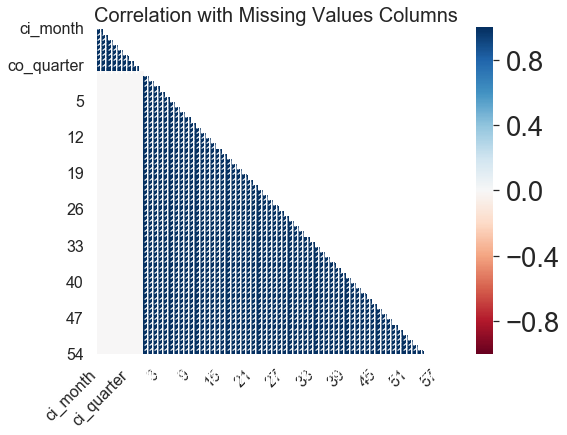

In [75]:
missing_value_columns = train_new_feature.columns[train_new_feature.isnull().any()].tolist()
msno.heatmap(train_new_feature[missing_value_columns], figsize=(8,6))
plt.title("Correlation with Missing Values Columns", fontsize = 20)

- Original feature와 additional feature를 분리해서 correlation 확인

In [76]:
# Correlation between original features
train_new_feature[missing_value_columns[0:10]].corr()

,ci_month,co_month,ci_day,co_day,ci_dayofweek,co_dayofweek,ci_quarter,co_quarter,duration_of_stay,0
ci_month,1.000000,0.873947,0.082744,0.032258,-0.015949,-0.005016,0.969826,0.862663,-0.026266,0.000047
co_month,0.873947,1.000000,0.015597,0.103944,0.012383,-0.018293,0.863543,0.970444,-0.054036,0.001672
ci_day,0.082744,0.015597,1.000000,0.447204,0.004381,-0.006443,0.064212,0.005648,-0.012937,0.001708
co_day,0.032258,0.103944,0.447204,1.000000,0.004253,0.007678,0.022668,0.085781,0.003411,-0.001123
ci_dayofweek,-0.015949,0.012383,0.004381,0.004253,1.000000,-0.005458,-0.016473,0.007811,-0.010261,-0.005211
co_dayofweek,-0.005016,-0.018293,-0.006443,0.007678,-0.005458,1.000000,-0.000940,-0.016284,-0.029400,0.001133
ci_quarter,0.969826,0.863543,0.064212,0.022668,-0.016473,-0.000940,1.000000,0.901538,-0.029875,-0.001007
co_quarter,0.862663,0.970444,0.005648,0.085781,0.007811,-0.016284,0.901538,1.000000,-0.050721,0.000911
duration_of_stay,-0.026266,-0.054036,-0.012937,0.003411,-0.010261,-0.029400,-0.029875,-0.050721,1.000000,-0.028298
0,0.000047,0.001672,0.001708,-0.001123,-0.005211,0.001133,-0.001007,0.000911,-0.028298,1.000000


In [77]:
# Correlation between destination features
train_new_feature[missing_value_columns[11:]].corr()

,2,3,4,5,6,7,8,9,10,11,...,50,51,52,53,54,55,56,57,58,srch_destination_iddestination_compression
2,1.000000,0.278453,-0.115095,0.037319,-0.067079,0.043300,0.043698,0.220585,-0.043102,-0.033205,...,0.084222,-0.015113,-0.140034,-0.089110,0.056182,0.060498,0.058210,0.202560,-0.046138,-0.039508
3,0.278453,1.000000,-0.281725,0.147770,-0.316607,-0.168468,0.093594,0.264916,0.053990,-0.049285,...,0.080887,-0.024210,-0.182715,-0.089759,0.004909,0.074902,0.044813,0.154380,0.037735,-0.097875
4,-0.115095,-0.281725,1.000000,-0.105240,0.250030,0.070898,0.022219,-0.092238,-0.128903,-0.140827,...,-0.015593,0.050858,0.048078,0.036037,0.030346,-0.036613,0.025578,-0.076272,0.018503,0.006881
5,0.037319,0.147770,-0.105240,1.000000,-0.138361,-0.049341,0.076425,0.146606,0.000850,-0.148027,...,0.038029,0.062741,-0.111777,-0.026008,-0.020558,0.041495,-0.090898,-0.008724,0.007689,-0.001352
6,-0.067079,-0.316607,0.250030,-0.138361,1.000000,0.138771,-0.027229,-0.256987,-0.001794,0.105350,...,0.068883,0.077077,0.120619,0.027097,-0.003895,0.001422,0.002958,-0.089572,-0.133598,0.041278
7,0.043300,-0.168468,0.070898,-0.049341,0.138771,1.000000,-0.171094,-0.046625,-0.021268,0.219290,...,-0.093443,-0.120277,-0.028074,-0.044784,-0.004560,-0.071441,0.108581,-0.022707,-0.088471,-0.023218
8,0.043698,0.093594,0.022219,0.076425,-0.027229,-0.171094,1.000000,-0.026196,0.176501,-0.079343,...,0.117819,0.130238,0.052781,0.072716,0.050531,0.002519,-0.055545,-0.006350,0.018239,-0.022330
9,0.220585,0.264916,-0.092238,0.146606,-0.256987,-0.046625,-0.026196,1.000000,-0.112144,-0.062366,...,-0.075087,-0.136623,-0.168638,-0.202358,0.078977,0.050046,0.050509,0.050767,-0.021532,-0.006558
10,-0.043102,0.053990,-0.128903,0.000850,-0.001794,-0.021268,0.176501,-0.112144,1.000000,-0.060156,...,0.172355,0.110687,-0.091719,0.012001,-0.078533,0.116243,-0.125337,0.068406,-0.009598,0.006715
11,-0.033205,-0.049285,-0.140827,-0.148027,0.105350,0.219290,-0.079343,-0.062366,-0.060156,1.000000,...,-0.018052,0.009781,0.039370,0.024907,0.005730,-0.115062,0.115544,0.003683,-0.034667,0.025543


## srch_destination_id missing value 전략
- feature 간의 상관관계가 없고, 전체 dataset 중에서 missing value가 차지하는 비율이 매우 적음
- missing value를 처리하는 여러 방법 중, 제거하는 방법을 선택

In [78]:
train_new_feature.dropna(inplace=True)

In [79]:
for col in train_new_feature.columns:
    print(col, train_new_feature[col].isnull().sum())

quarter 0
month 0
dayofweek 0
day 0
hour 0
minute 0
ci_month 0
co_month 0
ci_day 0
co_day 0
ci_dayofweek 0
co_dayofweek 0
ci_quarter 0
co_quarter 0
duration_of_stay 0
site_name 0
posa_continent 0
user_location_country 0
user_location_region 0
user_location_city 0
orig_destination_distance 0
user_id 0
is_mobile 0
is_package 0
channel 0
srch_adults_cnt 0
srch_children_cnt 0
srch_rm_cnt 0
srch_destination_id 0
srch_destination_type_id 0
is_booking 0
cnt 0
hotel_continent 0
hotel_country 0
hotel_market 0
hotel_cluster 0
year 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
srch_destination_iddestination_compression 0


In [80]:
train_new_feature = train_new_feature.drop("srch_destination_iddestination_compression", axis=1)

In [81]:
train_new_feature.describe()

,quarter,month,dayofweek,day,hour,minute,ci_month,co_month,ci_day,co_day,...,49,50,51,52,53,54,55,56,57,58
count,1.244317e+06,1.244317e+06,1.244317e+06,1.244317e+06,1.244317e+06,1.244317e+06,1.244317e+06,1.244317e+06,1.244317e+06,1.244317e+06,...,1.244317e+06,1.244317e+06,1.244317e+06,1.244317e+06,1.244317e+06,1.244317e+06,1.244317e+06,1.244317e+06,1.244317e+06,1.244317e+06
mean,2.707354e+00,7.147298e+00,2.789771e+00,1.584611e+01,1.360147e+01,2.958923e+01,7.133310e+00,6.969240e+00,1.617573e+01,1.600888e+01,...,-8.042621e-04,-9.536607e-04,-1.359559e-04,2.318042e-04,6.826960e-04,1.318768e-04,1.974036e-04,3.266116e-04,1.775612e-04,3.383114e-05
std,1.069416e+00,3.268180e+00,1.995976e+00,8.769168e+00,5.661332e+00,1.729956e+01,3.364285e+00,3.399248e+00,8.873661e+00,9.016671e+00,...,1.652689e-02,1.592957e-02,1.189338e-02,1.014639e-02,9.691500e-03,6.639770e-03,6.658866e-03,6.985981e-03,4.487306e-03,2.672257e-03
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,-2.409961e-01,-2.397938e-01,-1.919475e-01,-2.860810e-01,-1.018862e-01,-1.505922e-01,-1.723210e-01,-1.569399e-01,-8.895885e-02,-1.247743e-01
25%,2.000000e+00,5.000000e+00,1.000000e+00,8.000000e+00,1.000000e+01,1.500000e+01,4.000000e+00,4.000000e+00,9.000000e+00,8.000000e+00,...,-1.852011e-03,-2.515940e-03,-1.600519e-03,-3.705458e-03,-2.883522e-03,-8.264213e-04,-8.846109e-04,-8.118544e-04,-9.162736e-04,-4.600120e-04
50%,3.000000e+00,7.000000e+00,3.000000e+00,1.600000e+01,1.400000e+01,3.000000e+01,7.000000e+00,7.000000e+00,1.600000e+01,1.600000e+01,...,3.507179e-04,-2.648432e-04,-2.585825e-04,9.358452e-04,-1.055254e-03,9.559524e-05,2.336693e-04,5.010670e-05,1.486969e-05,-1.032606e-04
75%,4.000000e+00,1.000000e+01,4.000000e+00,2.300000e+01,1.800000e+01,4.500000e+01,1.000000e+01,1.000000e+01,2.400000e+01,2.400000e+01,...,1.690306e-03,1.314098e-03,3.317939e-03,2.839453e-03,2.187647e-03,1.671127e-03,1.825654e-03,1.849599e-03,1.696772e-03,2.973983e-04
max,4.000000e+00,1.200000e+01,6.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,1.200000e+01,1.200000e+01,3.100000e+01,3.100000e+01,...,1.936012e-01,2.114327e-01,1.741851e-01,1.370762e-01,2.107999e-01,1.133511e-01,1.905134e-01,1.780266e-01,1.959012e-01,2.030989e-01


# 2. Hotel cluster classification